In [301]:
import math
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from scipy.stats import norm
sns.set()


# simulate stock prices paths:
def St_simulation_SDE(S0, T, N, r, sig):
    dt = T/N
    dBs = np.random.normal(0, dt**0.5, N)
    path = []
    St = S0
    path.append(St)
    for i,dB_i in enumerate(dBs):
        St = St + sig*St*dB_i+r*St*dt
        path.append(St)
    return path


# N(d1)
def d1_v(St, K, sigma, expir_t, r):
    d1 = (math.log(St/K) + (r+0.5*sigma**2)*expir_t)/(sigma*expir_t**0.5)
    N1 = norm.cdf(d1)
    return N1


# N(d2)
def d2_v(St, K, sigma, expir_t, r):
    d2 = (math.log(St/K) + (r-0.5*sigma**2)*expir_t)/(sigma*expir_t**0.5)
    N2 = norm.cdf(d2)
    return N2


# Call option vaue at time t
def Ct_v(St, K, sigma, expir_t, r):
    N1 = d1_v(St, K, sigma, expir_t, r)
    N2 = d2_v(St, K, sigma, expir_t, r)
    Ct = St*N1 - K*math.exp(-r*expir_t)*N2
    return Ct


# call option path
def Ct_value(path, K, T, N, sigma):
    dt = T/N
    Ct_path = []
    Deltas = []
    Deltas_dis = []
    for i in range(N):
        St = path[i]
        Ti = T - i*dt
        Ct = Ct_v(St, K, sigma, Ti, r)
        Ct_path.append(Ct)
    return Ct_path


# get the arithmetic average
def avg_arith_val(path):
    return np.sum(path)/len(path)


# get the geometric average
def avg_geome_val(path):
    return np.prod(np.array(path)/100)**(1/len(path))*100


# get arithmetic average path:
def avg_arith_path(path):
    arith_path = []
    for i in range(len(path)):
        avg_arith = avg_arith_val(path[0:i+1])
        arith_path.append(avg_arith)
    return arith_path


# get the geometric average path:
def avg_geome_path(path):
    geome_path = []
    for i in range(len(path)):
        avg_geome = avg_geome_val(path[0:i+1])
        geome_path.append(avg_geome)
    return geome_path


# Monte Carlo for asian call
def asian_monte_v(sum_now, St, S0, r, sig, K, T, N, step_i, simulate_times):
    dt = T/N
    N_left = N+1 - step_i
    et = T - (step_i-1)*dt
    disconut_f = math.exp(-r*et)
    Cts = []
    for i in range(simulate_times):
        if N_left>0:
            future_path = St_simulation_SDE(S0, et, N_left, r, sig)
            future_path = future_path[1:]
            all_sum = sum_now + St/S0 * np.sum(future_path)
            all_avg = all_sum/(N+1)
        else:
            all_avg = sum_now/(N+1)
        Ct = disconut_f* max(all_avg-K, 0)
        Cts.append(Ct)
    #print('the number future', len(future_path))
    simulate_Ct = np.sum(Cts)/len(Cts)
    return simulate_Ct


# Monte Carlo simulation for asian call path
def asian_monte_path(stock_path, r, sig, K, T, N, simulate_times):
    simulate_Cts = []
    length = len(stock_path)
    S0 = stock_path[0]
    for i in range(length):
        if i%100==0:
            print('processnig {} steps'.format(i))
        St = stock_path[i]
        sum_now = np.sum(stock_path[0:i+1])
        #print('the number until now', len(stock_path[0:i+1]))
        step_i = i+1
        simulate_Ct = asian_monte_v(sum_now, St, S0,
                      r, sig, K, T, N, step_i, simulate_times)
        simulate_Cts.append(simulate_Ct)
    return simulate_Cts


# pricing asian option with geometric average:
def Gt(gone_path, Nt):
    Gt_v = math.exp(1/Nt*np.sum(np.log(np.array(gone_path))))
    return Gt_v

def mu_bar(r, sig, T, et):
    mu_bar_v = (r-sig**2/2)*et**2/(2*T)
    return mu_bar_v

def sig_bar(sig, et):
    sig_bar2_v = sig**2*et**3/(3*T**2)
    return sig_bar2_v

def P2(t, et, St, Gt, mu_bar, sig_bar, K):
    p2_v = (t/T*math.log(Gt)+et/T*math.log(St)+mu_bar-math.log(K))/sig_bar
    return p2_v
    
def P1(t, et, St, Gt, mu_bar, sig_bar, K):
    p2_v = P2(t, et, St, Gt, mu_bar, sig_bar, K)
    p1_v = p2_v + sig_bar
    return p1_v


# asian option price at time t
def asian_gemom_v(r, sig, T, t, et, St, gone_path, step_i):
    Gt_v = Gt(gone_path, step_i)
    mu_bar_v = mu_bar(r, sig, T, et)
    sig_bar_v = sig_bar(sig, et)**0.5
    p1_v = P1(t, et, St, Gt_v, mu_bar_v, sig_bar_v, K)
    NP1 = norm.cdf(p1_v)
    p2_v = P2(t, et, St, Gt_v, mu_bar_v, sig_bar_v, K)
    NP2 = norm.cdf(p2_v)
    disconut_f = math.exp(-r*et)
    GSENP1 = Gt_v**(t/T)*St**(et/T)*math.exp(mu_bar_v+sig_bar_v**2/2)*NP1
    Ct = disconut_f*(GSENP1-K*NP2)
    return Ct

    
def asian_gemom(stock_path, r, sig, T, N, K):
    dt = T/N
    Cts = []
    for i in range(N):
        t = i*dt
        et = T - t
        gone_path = stock_path[0:i+1]
        St = stock_path[i]
        step_i = i + 1
        Ct = asian_gemom_v(r, sig, T, t, et, St, gone_path, step_i)
        Cts.append(Ct)
    return Cts
    

# exercise 2 ------------------------#
# simulate the interest rate path
def Rt_simulation_SDE(r0, T, N, a, b, sig):
    dt = T/N
    dBs = np.random.normal(0, dt**0.5, N)
    path = []
    rt = r0
    path.append(rt)
    for i,dB_i in enumerate(dBs):
        rt = rt + sig*dB_i+b*(a-rt)*dt
        path.append(rt)
    return path


def ATBT(a, b, T, t, sig):
    et = T - t
    BT_v = 1/b*(1-math.exp(-b*et))
    AT_v = 1/b**2*(BT_v - T + t)*(b**2*a - 0.5*sig**2)- sig**2*(BT_v)**2/(4*b)
    return AT_v, BT_v

def bond_price(rt, a, b, sig, T, t,  et):
    AT_v, BT_v = ATBT(a, b, T, t, sig)
    return math.exp(AT_v-rt*BT_v)

def bond_price_path(rts, a, b, sig, T, N):
    dt = T/N
    price_path = []
    for i in range(N+1):
        rt = rts[i]
        t = i*dt
        et = T - t
        price_i = bond_price(rt, a, b, sig, T, t, et)
        price_path.append(price_i)
    return price_path


def yield_curve(r0, Tb, a, b, sig):
    t = 0
    dt = Tb/N
    yTs = []
    for i in range(1000):
        T = (i+1)*dt
        et = T
        bond_price_i = bond_price(r0, a, b, sig, T, t, et)
        yT = -1/T * math.log(bond_price_i)
        yTs.append(yT)
    return yTs


# plot
def plot_path(paths, names, T, xname, yname, img_path=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'brown', 'gray', 'darkorange']
    num = len(names)
    plt.figure(figsize=(6, 4))
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    for i in range(num):
        path_i = paths[i]
        num_ps = len(path_i)  
        index = [i*T/(num_ps-1) for i in range(num_ps)]
        plt.plot(index, path_i, color=colors[i], 
                 linestyle="-", linewidth=0.9, label=names[i])
        
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title('{}@{}'.format(yname,xname))
    plt.legend()
    if img_path != None:
        plt.savefig(img_path)
    plt.show()


# step1: plot arithmetic and geometric average:
def plot_avgs(stock_path, T,  img_path=None):
    arith_path = avg_arith_path(stock_path)
    geome_path = avg_geome_path(stock_path)
    paths = [stock_path, arith_path, geome_path]
    names = ['spot value', 'arithmetic average', 'geometric average']
    xname = 'time'
    yname = 'value'
    plot_path(paths, names, T, xname, yname, img_path)


def exercise1():
    r = 0.05
    K = 105
    S0 = 100
    Sigma = 0.20
    N = 1000
    T = 1
    simulate_times = 3000
    stock_path = St_simulation_SDE(S0, T, N, r, Sigma)
    save_root = './'
    avgs_path_img = os.path.join(save_root, 'avgs.png')
    plot_avgs(stock_path, T, img_path=avgs_path_img)

    # pricing by monte carlo with arithmetic average
    Aaisn_Cts_arith = asian_monte_path(stock_path, r, Sigma, K, T, N, simulate_times)
    Aaisn_Cts_geome = asian_gemom(stock_path, r, Sigma, T, N, K)
    Cts = Ct_value(stock_path, K, T, N, Sigma)
    print(Aaisn_Cts_arith[0], Aaisn_Cts_geome[0], Cts[0])
    calls_path = [Aaisn_Cts_arith, Aaisn_Cts_geome, Cts]
    names = ['asian_call_arithmetic', 'asian_call_geometric', 'call']
    xname = 'time'
    yname = 'value'
    calls_path_img = os.path.join(save_root, 'calls.png')
    plot_path(calls_path, names, T, xname, yname, img_path=calls_path_img)

In [ ]:
3.4986752232937444 3.325054206117619 8.021352235143176

# 2 Bond prices with Vasicek model for interest rates

## 2.1 Simulate several realizations of the process for diﬀerent values of b, a, σ.

the mean value of last point 0.050472235691278726


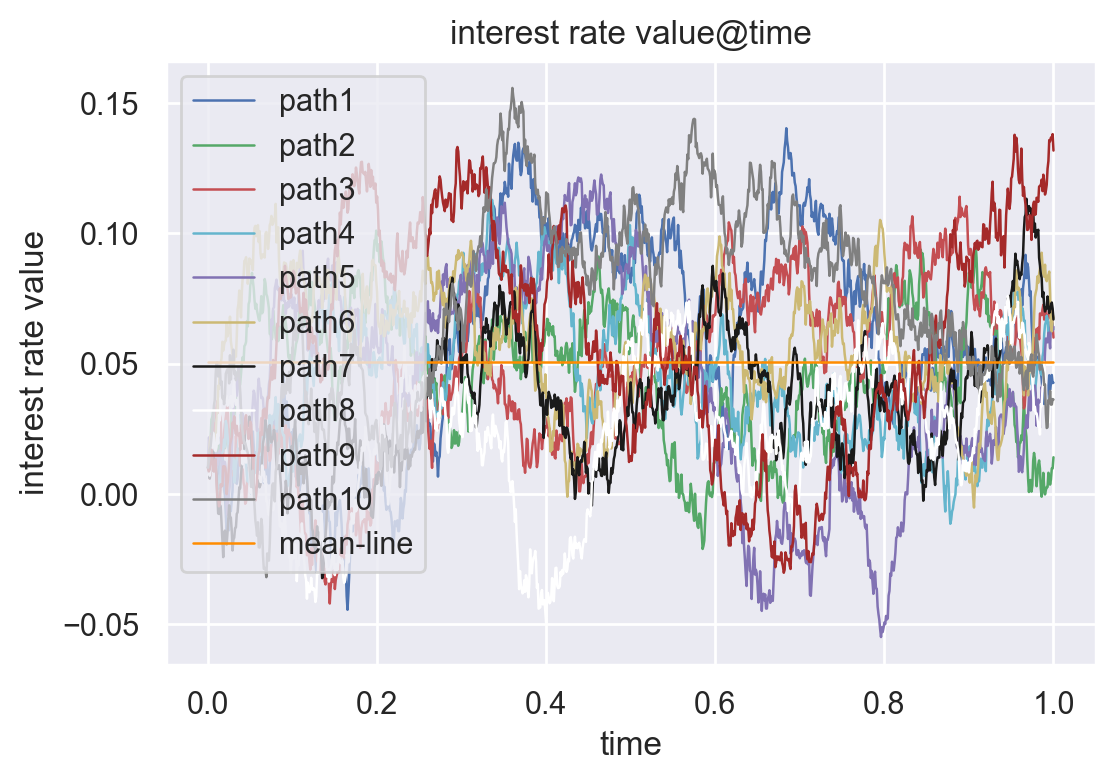

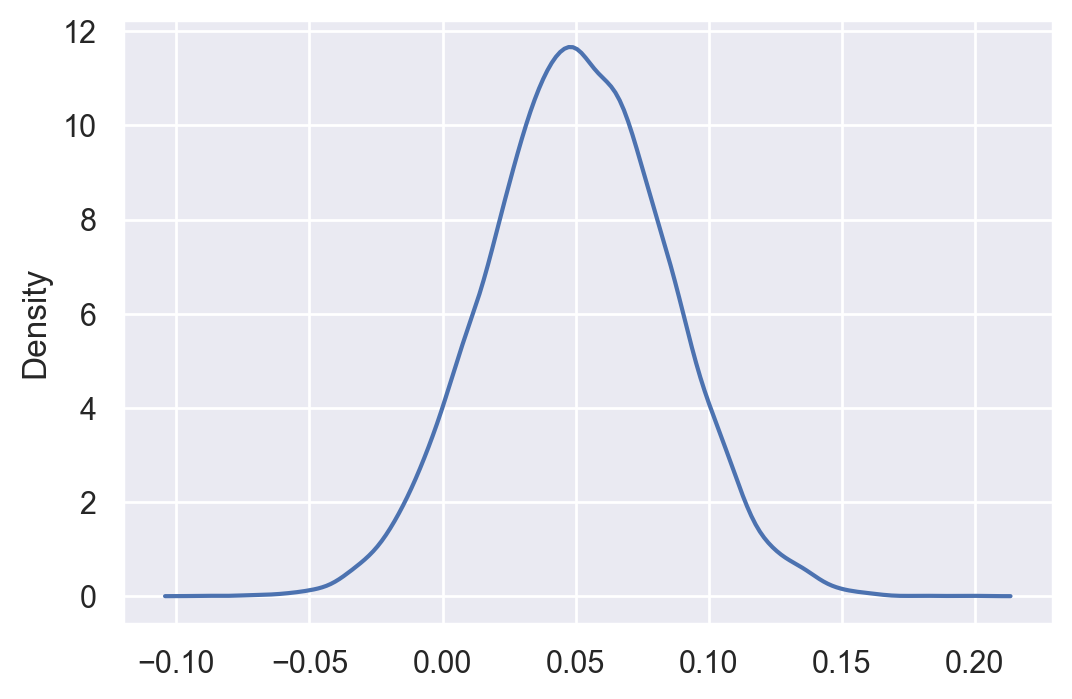

In [303]:
T = 1
N = 1000
sig = 0.15
r0 = 0.01
a = 0.05
b = 10
lasts = []
paths = []
names = []
j = 0
for i in range(10000):
    Rts = Rt_simulation_SDE(r0, T, N, a, b, sig)
    lasts.append(Rts[-1])
    if i % 1000 == 0:
        j += 1
        paths.append(Rts)
        names.append('path{}'.format(j))
mean = np.sum(lasts)/len(lasts)
mean_line = [mean for i in range(len(Rts))]
paths.append(mean_line)
names.append('mean-line')
print('the mean value of last point {}'.format(mean))
yname = 'interest rate value'
xname = 'time'
calls_path_img = './interest_paths.png'
plot_path(paths, names, T, xname, yname, img_path=calls_path_img)
sns_plot = sns.kdeplot(lasts, x="last value")
fig = sns_plot.get_figure()
fig.savefig("last_distribution.png")

## 2.2 bond prices

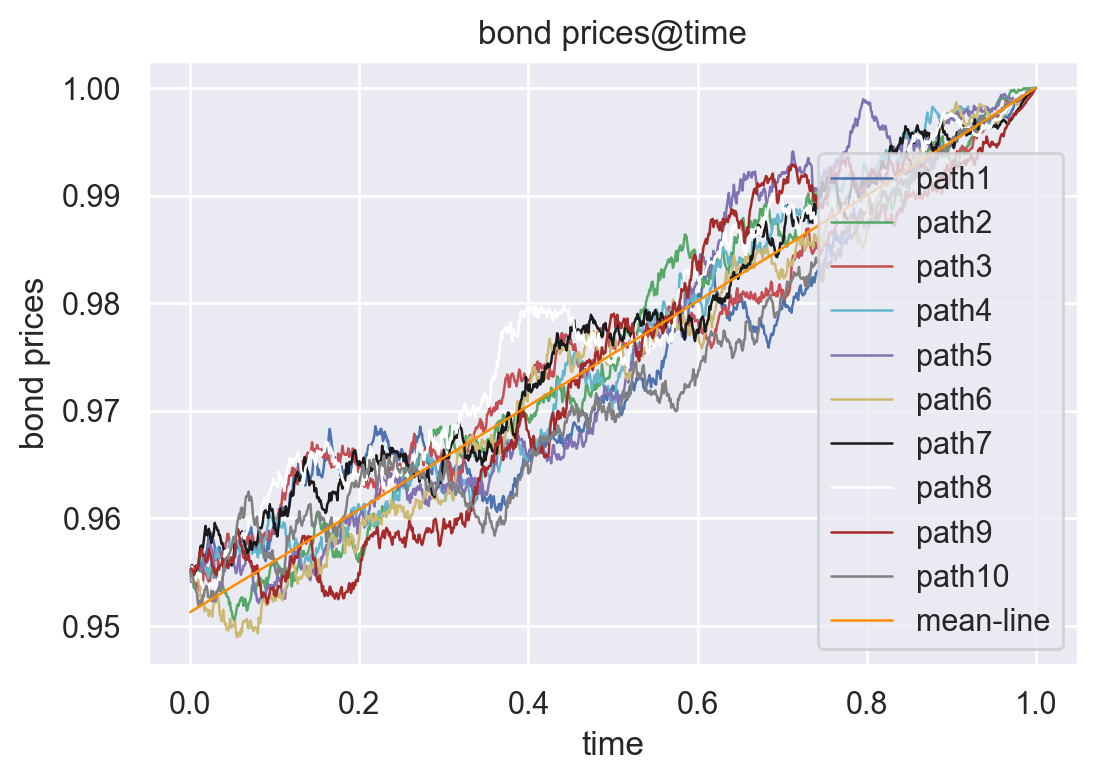

In [306]:
bond_path = []
for path_i in paths:
    price_path = bond_price_path(path_i, a, b, sig, T, N)
    bond_path.append(price_path)
yname = 'bond prices'
xname = 'time'
calls_path_img = './bond_prices.png'
plot_path(bond_path, names, T, xname, yname, img_path=calls_path_img)

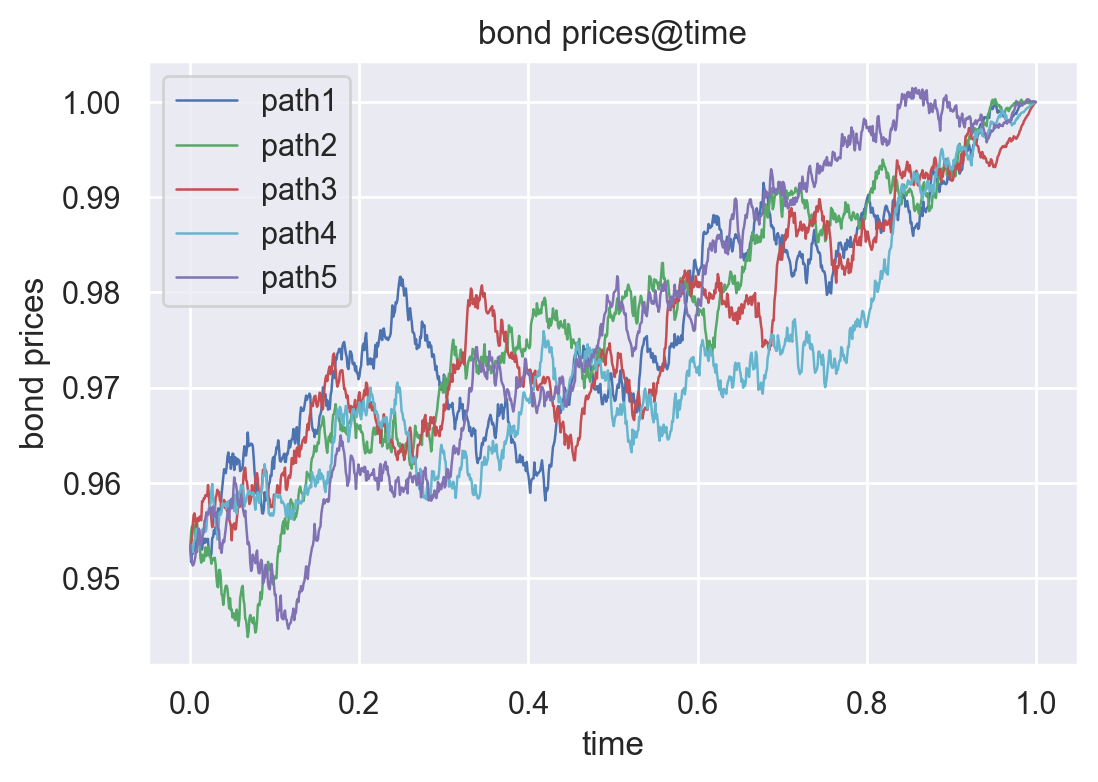

In [340]:
T = 1
N = 1000
sig = 0.25
r0 = 0.03
a = 0.05
b = 10
lasts = []
paths = []
names = []
j = 0
for i in range(5):
    Rts = Rt_simulation_SDE(r0, T, N, a, b, sig)
    paths.append(Rts)    
    names.append('path{}'.format(i+1))
bond_path = []
for path_i in paths:
    price_path = bond_price_path(path_i, a, b, sig, T, N)
    bond_path.append(price_path)
yname = 'bond prices'
xname = 'time'
calls_path_img = './bond_prices1.png'
plot_path(bond_path, names, T, xname, yname, img_path=calls_path_img)

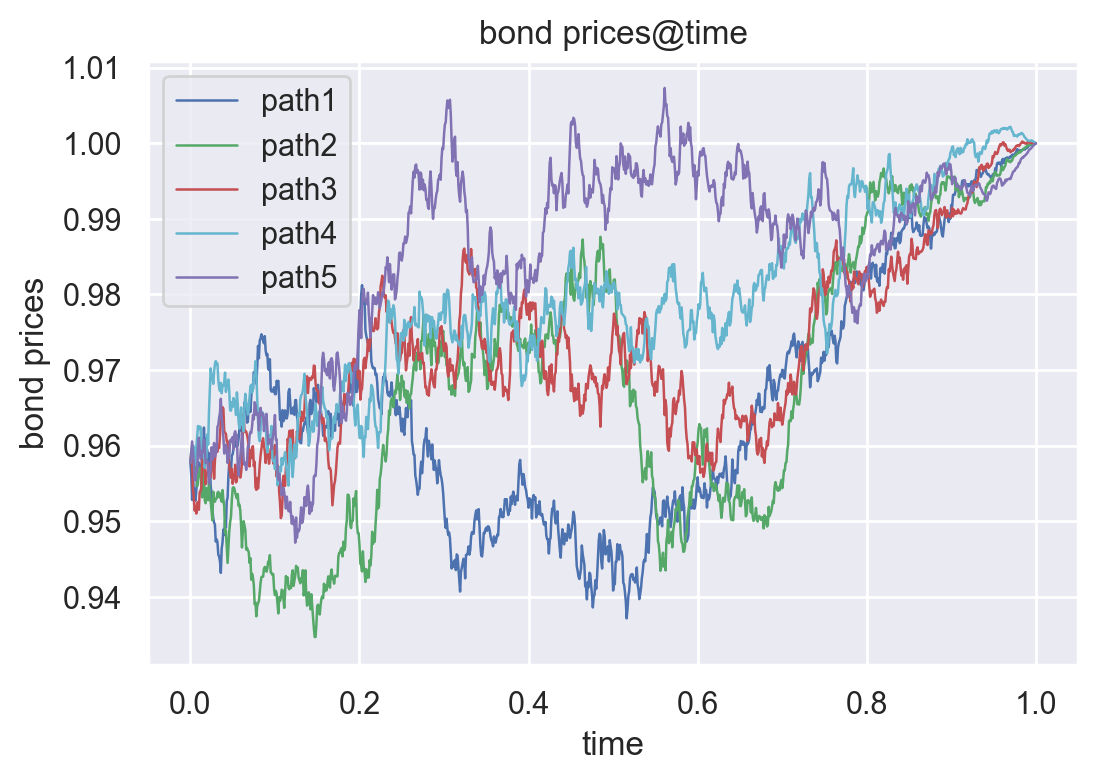

In [338]:
T = 1
N = 1000
sig = 0.25
r0 = 0.02
a = 0.05
b = 5
lasts = []
paths = []
names = []
j = 0
for i in range(5):
    Rts = Rt_simulation_SDE(r0, T, N, a, b, sig)
    paths.append(Rts)    
    names.append('path{}'.format(i+1))
bond_path = []
for path_i in paths:
    price_path = bond_price_path(path_i, a, b, sig, T, N)
    bond_path.append(price_path)
yname = 'bond prices'
xname = 'time'
calls_path_img = './bond_prices2.png'
plot_path(bond_path, names, T, xname, yname, img_path=calls_path_img)

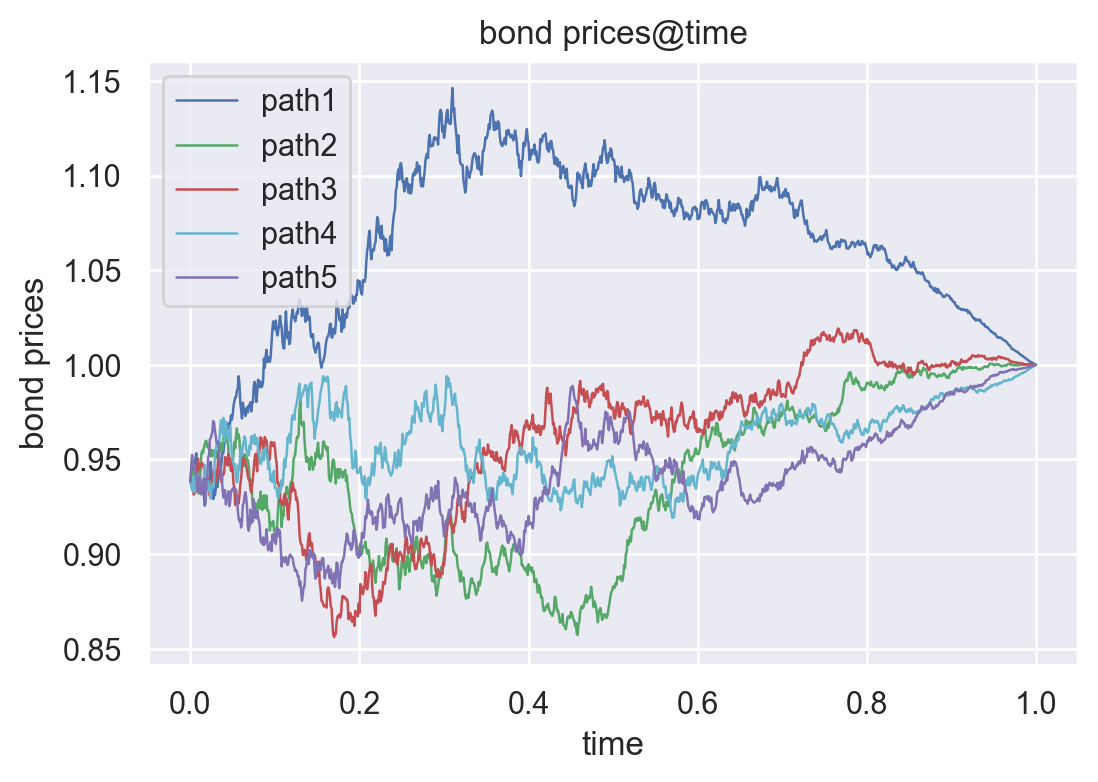

In [330]:
T = 1
N = 1000
sig = 0.25
r0 = 0.08
a = 0.05
b = 1
lasts = []
paths = []
names = []
j = 0
for i in range(5):
    Rts = Rt_simulation_SDE(r0, T, N, a, b, sig)
    paths.append(Rts)    
    names.append('path{}'.format(i+1))
bond_path = []
for path_i in paths:
    price_path = bond_price_path(path_i, a, b, sig, T, N)
    bond_path.append(price_path)
yname = 'bond prices'
xname = 'time'
calls_path_img = './bond_prices3.png'
plot_path(bond_path, names, T, xname, yname, img_path=calls_path_img)

## 2.3 yield to maturity

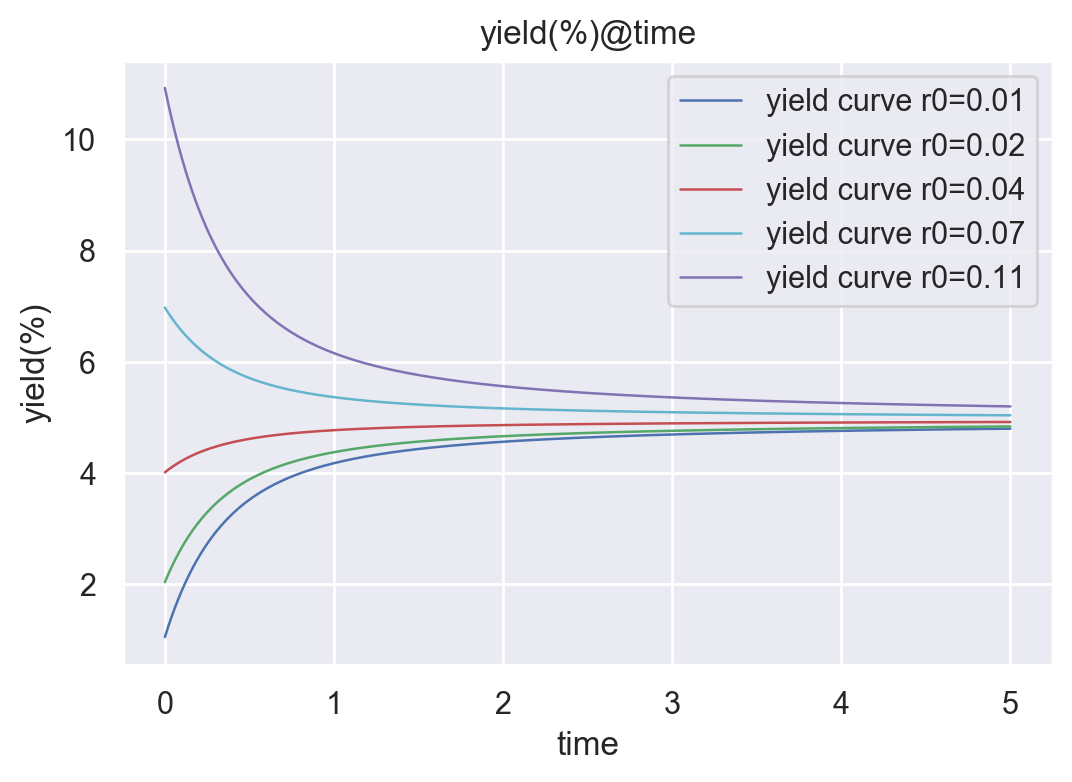

In [318]:
sig = 0.15
a,b = 0.05, 5
r0 = 0.01
yts = []
names = []
T = 5
for i in range(5):
    r0 = r0 + i* 0.01
    yt = yield_curve(r0, T, a, b, sig)
    yt = (np.array(yt)*100).tolist()
    yts.append(yt)
    names.append('yield curve r0={}'.format(round(r0,2)))

yname = 'yield(%)'
xname = 'time'
path_img = './yield.png'
plot_path(yts, names, T, xname, yname, img_path=path_img)

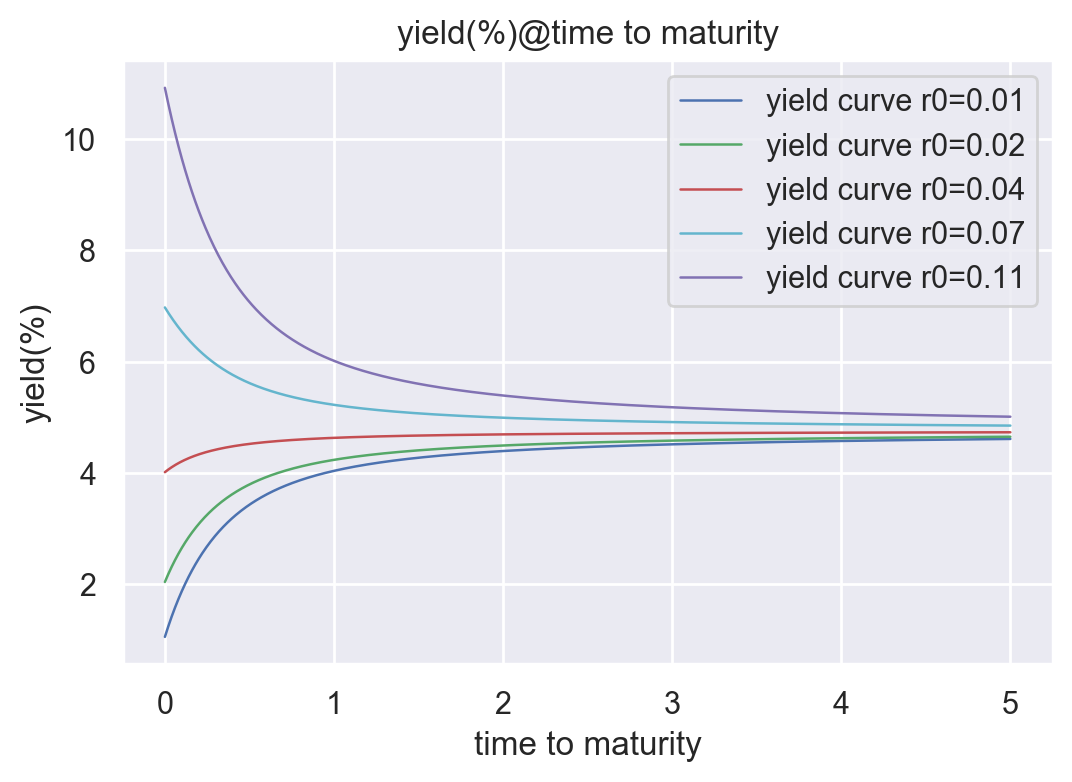

In [341]:
sig = 0.35
a,b = 0.05, 5
r0 = 0.01
yts = []
names = []
T = 5
for i in range(5):
    r0 = r0 + i* 0.01
    yt = yield_curve(r0, T, a, b, sig)
    yt = (np.array(yt)*100).tolist()
    yts.append(yt)
    names.append('yield curve r0={}'.format(round(r0,2)))

yname = 'yield(%)'
xname = 'time to maturity'
path_img = './yield.png'
plot_path(yts, names, T, xname, yname, img_path=path_img)

0.02
0.03
0.04
0.05
0.06
0.07
0.08


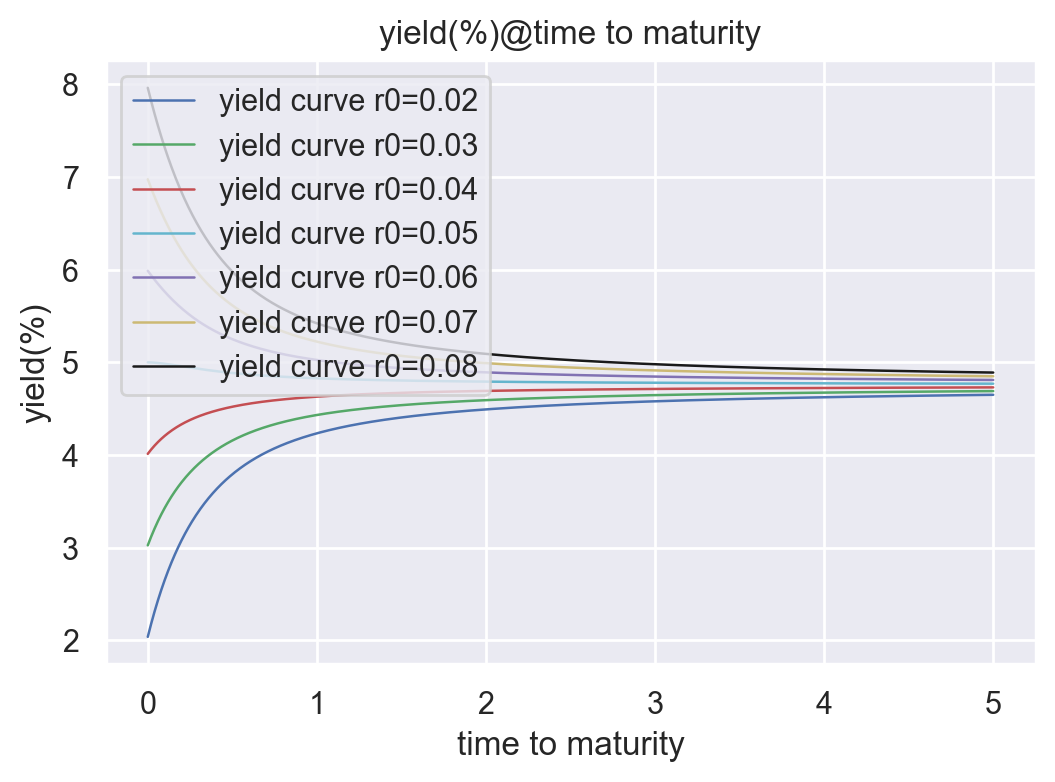

In [369]:
sig = 0.35
a,b = 0.05, 5
r0 = 0.01
yts = []
names = []
T = 5
for i in range(7):
    r0 = 0.02 + i* 0.01
    print(r0)
    yt = yield_curve(r0, T, a, b, sig)
    yt = (np.array(yt)*100).tolist()
    yts.append(yt)
    names.append('yield curve r0={}'.format(round(r0,2)))

yname = 'yield(%)'
xname = 'time to maturity'
path_img = './yield.png'
plot_path(yts, names, T, xname, yname, img_path=path_img)